<img src="fgv.png" align="right" height="104" width="240" >
TCC
========
#### Helder Rezende
------

In [355]:
import pandas as pd
from datetime import datetime
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas_datareader.data as web
import seaborn as sns
import statsmodels.api as sm
from arch import arch_model
import arch
import scipy
from scipy.stats import t
from scipy.optimize import fmin
import warnings
import os
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

%matplotlib inline

### Referências bibliográficas 

http://www.crest.fr/ckfinder/userfiles/files/pageperso/fermania/chapter-book-copula-density-estimation.pdf

https://risk-engineering.org/VaR/

http://www.analyticsresearch.net/Documents/2013AFEsession5.Practicals.pdf

financephd.typepad.com/files/copulas.pdf

http://www.impa.br/opencms/pt/ensino/downloads/mestrado_profissional_projeto_fim_curso/projetos_fim_cursos_2013/Cristiane_Azevedo.pdf


http://epub.lib.aalto.fi/fi/ethesis/pdf/12049/hse_ethesis_12049.pdf

financephd.typepad.com/files/copulas.pdf

http://arch.readthedocs.io/en/latest/univariate/introduction.html

### Introdução

O objetivo do trabalho primeiramente é analisar os modelos de VAR e volatilidade na crise brasileira.

In [464]:
ativos = ['RADL3', 'BRML3','ABEV3','PCAR4']
N = len(ativos)
cotacoes_list = []   
for x in ativos:
    cotacoes_list.append( web.DataReader(x + ".SA", data_source='yahoo', start='1/1/2014', end = '3/20/2016')['Close'])

/usr/local/lib/python3.5/dist-packages/pandas_datareader/base.py:47: DeprecationWarning: pandas.core.common.is_number is deprecated. import from the public API: pandas.api.types.is_number instead
  start, end = self._sanitize_dates(start, end)
/usr/local/lib/python3.5/dist-packages/pandas_datareader/data.py:94: ResourceWarning: unclosed <socket.socket fd=72, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.22.145.4', 46104), raddr=('200.152.162.135', 80)>
  session=session).read()
/usr/local/lib/python3.5/dist-packages/pandas_datareader/data.py:94: ResourceWarning: unclosed <socket.socket fd=71, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.22.145.4', 52836), raddr=('200.152.162.161', 80)>
  session=session).read()
/usr/local/lib/python3.5/dist-packages/pandas_datareader/data.py:94: ResourceWarning: unclosed <socket.socket fd=71, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.22.145.4', 46108

In [465]:
cotacoes_list = [cotacoesFibr,cotacoesPetr,cotacoesItub,cotacoesBbdc]
cotacoes = pd.DataFrame(index = ativos, data = cotacoes_list).transpose().dropna()
cotacoes_carteira = cotacoes.sum(axis=1)/4

In [466]:
def log_retorno(cotacoes):
    return np.log((cotacoes / cotacoes.shift(1)))[1:]

In [467]:
retornos = [log_retorno(cotacoes_list[x]) for x in range(len(cotacoes_list))]
retornos = pd.DataFrame(index = ativos, data = retornos)
retornos = retornos.transpose().dropna()

/usr/local/lib/python3.5/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.5/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


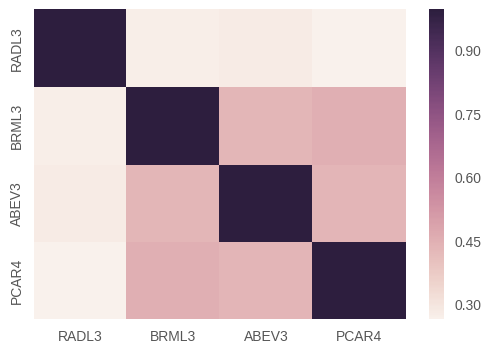

In [468]:
corr = retornos.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [469]:
corr

,RADL3,BRML3,ABEV3,PCAR4
RADL3,1.000000,0.276418,0.285660,0.267230
BRML3,0.276418,1.000000,0.436086,0.456285
ABEV3,0.285660,0.436086,1.000000,0.437079
PCAR4,0.267230,0.456285,0.437079,1.000000


In [470]:
retornos_carteira = retornos.sum(axis=1)/4

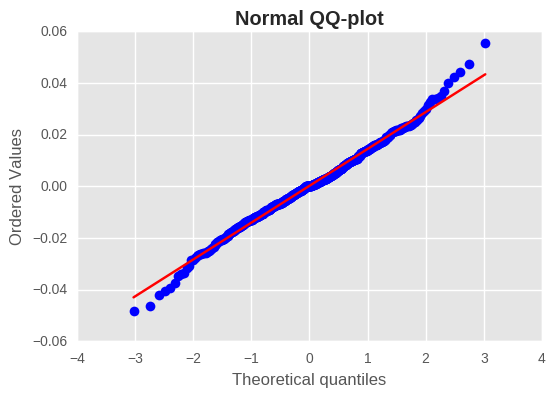

In [471]:
Q = retornos_carteira.as_matrix()
scipy.stats.probplot(Q, dist=scipy.stats.norm, plot=plt.figure().add_subplot(111))
plt.title(u"Normal QQ-plot", weight="bold");

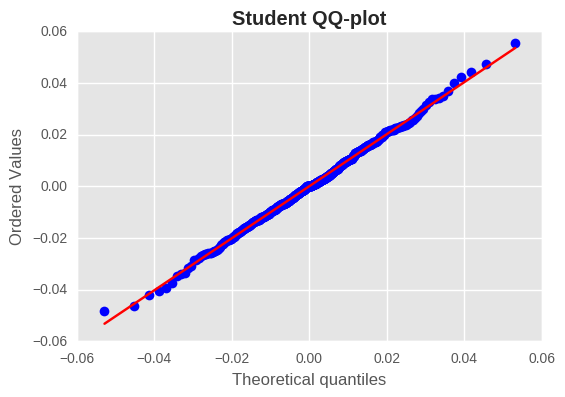

In [472]:
tdf, tmean, tsigma = scipy.stats.t.fit(Q)
scipy.stats.probplot(Q, dist=scipy.stats.t, sparams=(tdf, tmean, tsigma), plot=plt.figure().add_subplot(111))
plt.title(u"Student QQ-plot", weight="bold");

### BackTesting - Configuração

#### Kupiec Tests 

Tabela de Não-Rejeição de acordo o numero de falhas N.

In [474]:
Kupiec = pd.DataFrame(index = [0.01,0.025,0.05,0.075,0.01])

In [755]:
Kupiec["VaR"] = ["99%"," 97.5","95%", "92.5%","90%"]
Kupiec["T = 255 dias"] = ["N<7", "2<N<12", "6<N<21", "11<N<28", "16<N<36"]
Kupiec["T = 510 dias"] = ["1<N<11", "6<N<21", "16<N<36", "27<N<51", "38<N<65"]
Kupiec["T = 1000 dias"] = ["4<N<17", "15<N<36", "37<N<65", "59<N<92", "81<N<120"]
Kupiec

,VaR,T = 255 dias,T = 510 dias,T = 1000 dias
0.010,99%,N<7,1<N<11,4<N<17
0.025,97.5,2<N<12,6<N<21,15<N<36
0.050,95%,6<N<21,16<N<36,37<N<65
0.075,92.5%,11<N<28,27<N<51,59<N<92
0.010,90%,16<N<36,38<N<65,81<N<120


### 1 - VaR histórico

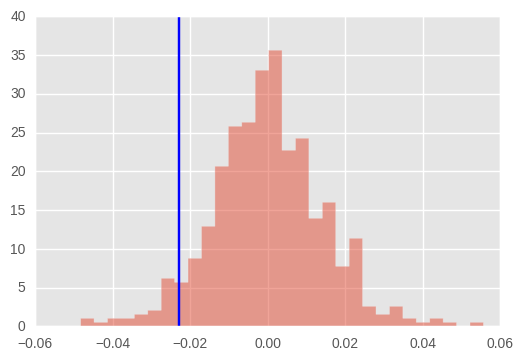

In [477]:
confianca = 0.95

retornos_carteira.hist(bins=30,normed=True,histtype='stepfilled',alpha=0.5)

plt.axvline(x=retornos_carteira.quantile([1-confianca,confianca])[1-confianca], color='b')

In [478]:
def var_historico(retornos, confianca):
    
    return retornos.quantile(1-confianca)
        

In [479]:
var_99_historico = retornos_carteira.quantile(1-0.99)
var_95_historico = retornos_carteira.quantile(1-0.95)
var_90_historico = retornos_carteira.quantile(1-0.90)

cvar_99_historico=[]
cvar_95_historico=[]
cvar_90_historico=[]

for x in retornos_carteira:
    if x <var_99_historico:
        cvar_99_historico.append(x)
    if x <var_95_historico:
        cvar_95_historico.append(x)
    if x <var_90_historico:
        cvar_90_historico.append(x)

    
var_historico = pd.DataFrame(index =[0.90,0.95,0.99])
var_historico['VaR(%)'] = [var_90_historico*100,var_95_historico*100,var_99_historico*100]
var_historico['CVaR(%)'] = [np.mean(cvar_90_historico)*100,np.mean(cvar_95_historico)*100,np.mean(cvar_99_historico)*100]
var_historico

,VaR(%),CVaR(%)
0.90,-1.662841,-2.509471
0.95,-2.291965,-3.065612
0.99,-3.576870,-4.227028


### 1.2 BackTesting

In [480]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
inicio = len(retornos_carteira) - 255
final = len(retornos_carteira)
for x in range(inicio,final):
   
    lista_var95.append(retornos_carteira[x-255:x].quantile(0.05))
    if lista_var95[-1] > retornos_carteira.iloc[x-1]:
        count95 += 1
    lista_var90.append(retornos_carteira[x-255:x].quantile(0.1))
    if lista_var90[-1] > retornos_carteira.iloc[x-1]:
        count90 += 1
    lista_var99.append(retornos_carteira[x-255:x].quantile(0.01))
    if lista_var99[-1] > retornos_carteira.iloc[x-1]:
        count99 += 1
    
retornos_carteira_plot = retornos_carteira[inicio:final]

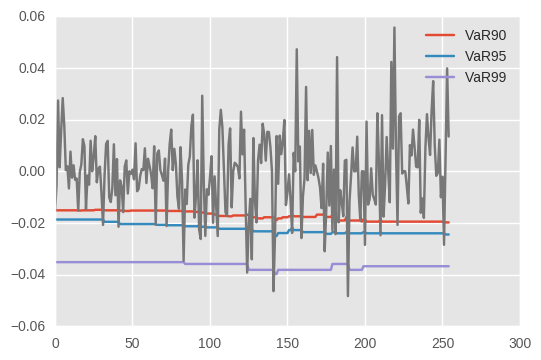

In [481]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_carteira_plot.as_matrix())
plt.legend()

In [482]:
backtesting_historio = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 255 dias"])
backtesting_historio["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_historio

,Excecoes para 255 dias,T = 255 dias
VaR 90,31,16<N<36
VaR 95,19,6<N<21
VaR 99,3,N<7


### 2 - VaR paramétrico

#### 2.1 - Calculando a volatilidade histórica

In [483]:
volatilidade_valores = []

volatilidade_valores_com_na = pd.rolling_std(retornos_carteira,60)
volatilidade_valores = volatilidade_valores_com_na.dropna()


volatilidade = pd.DataFrame(volatilidade_valores,columns = ["Index IBOVESPA"])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=60).std()
  app.launch_new_instance()


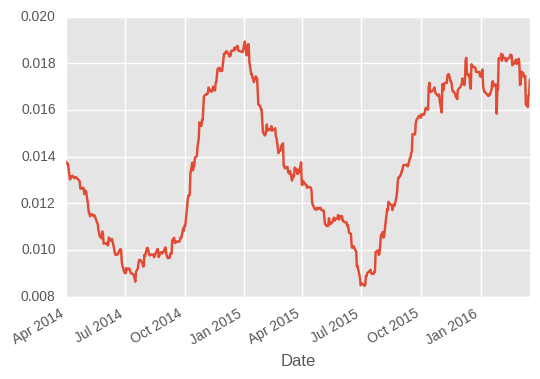

In [484]:
volatilidade_valores.plot()

#### 2.1.1 - VaR

In [485]:
var_parametrico = pd.DataFrame([1.28,1.65,2.23], index =[0.90,0.95,0.99], columns = ["Alpha"])

In [486]:
var_parametrico['VAR(%)'] = (volatilidade_valores.iloc[-1]) * var_parametrico*-100


In [487]:
var_parametrico

,Alpha,VAR(%)
0.90,1.28,-2.218019
0.95,1.65,-2.859165
0.99,2.23,-3.864205


#### 2.1.1.1 - BackTesting

In [488]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
for x in range(inicio,final):
   
    lista_var95.append(volatilidade_valores_com_na.iloc[x-1]*-1.65)
    if lista_var95[-1] > retornos_carteira.iloc[x-1]:
        count95 += 1
        
    lista_var90.append(volatilidade_valores_com_na.iloc[x-1]*-1.28)
    if lista_var90[-1] > retornos_carteira.iloc[x-1]:
        count90 += 1
        
    lista_var99.append(volatilidade_valores_com_na.iloc[x-1]*-2.23)
    if lista_var99[-1] > retornos_carteira.iloc[x-1]:
        count99 += 1
    

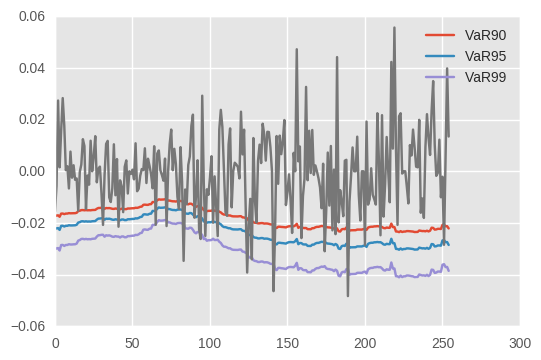

In [489]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_carteira_plot.as_matrix())
plt.legend()

In [490]:
backtesting_parametrico = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 252 dias"])
backtesting_parametrico["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_parametrico

,Excecoes para 252 dias,T = 255 dias
VaR 90,28,16<N<36
VaR 95,17,6<N<21
VaR 99,7,N<7


#### 2.2 - Calculando a volatidade usando EWMA

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(ignore_na=False,span=30,adjust=True,min_periods=0).mean()
  from ipykernel import kernelapp as app


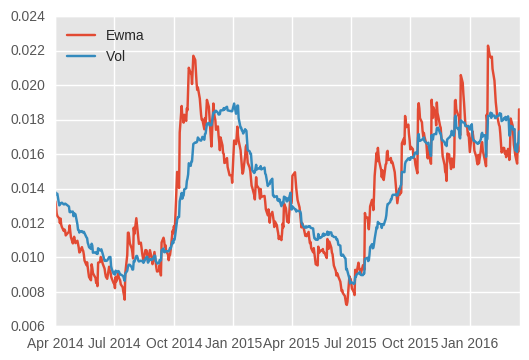

In [491]:
variance = retornos_carteira**2
ewma_variance = pd.ewma(variance, span = 30)
volatilidade_valores_ewma = pd.DataFrame([ewma_variance]).apply(sqrt)


plt.plot(volatilidade_valores_ewma[60:], label = 'Ewma')
plt.plot(volatilidade_valores, label = 'Vol')
plt.legend(loc = 2)

#### 2.2.1 - BackTesting

In [492]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
for x in range(inicio,final):
   
    lista_var95.append(volatilidade_valores_ewma.iloc[x-1]*-1.65)
    if lista_var95[-1] > retornos_carteira.iloc[x-1]:
        count95 += 1
        
    lista_var90.append(volatilidade_valores_ewma.iloc[x-1]*-1.28)
    if lista_var90[-1] > retornos_carteira.iloc[x-1]:
        count90 += 1
        
    lista_var99.append(volatilidade_valores_ewma.iloc[x-1]*-2.23)
    if lista_var99[-1] > retornos_carteira.iloc[x-1]:
        count99 += 1

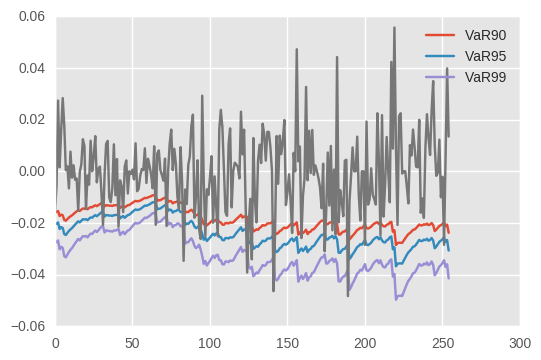

In [493]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_carteira_plot.as_matrix())
plt.legend()

In [494]:
backtesting_parametrico_ewma = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 252 dias"])

backtesting_parametrico_ewma["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_parametrico_ewma

,Excecoes para 252 dias,T = 255 dias
VaR 90,25,16<N<36
VaR 95,14,6<N<21
VaR 99,6,N<7


#### 2.2.1 - VaR

In [495]:
var_parametrico_ewma = pd.DataFrame([1.28,1.65,2.23], index =[0.90,0.95,0.99],columns = ["Alpha"])

In [496]:
var_parametrico_ewma['VAR(%)'] = (volatilidade_valores_ewma[-1]) * var_parametrico_ewma *100

In [497]:
var_parametrico_ewma

,Alpha,VAR(%)
0.90,1.28,2.343564
0.95,1.65,3.021000
0.99,2.23,4.082928


#### 2.3 - Calculando a volatidade usando GARCH(1,1)

In [498]:
am = arch_model(retornos_carteira)
res = am.fit(update_freq=5)
volatilidade_valores_garch = res.conditional_volatility

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1598.99602442
            Iterations: 2
            Function evaluations: 25
            Gradient evaluations: 2


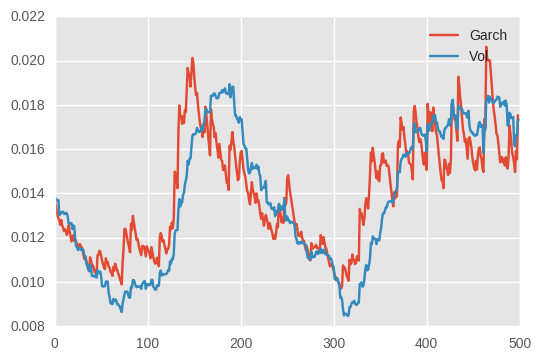

In [499]:
plt.plot(volatilidade_valores_garch.as_matrix()[60:], label='Garch')
plt.plot(volatilidade_valores.as_matrix(), label = 'Vol')
plt.legend()

#### 2.3.1 - VaR

In [500]:
var_parametrico_garch = pd.DataFrame([1.28,1.65,2.23], index =[0.90,0.95,0.99],columns = ["Alpha"])
var_parametrico_garch['VAR(%)'] = (volatilidade_valores_garch[-1]) * var_parametrico_garch *100
var_parametrico_garch

,Alpha,VAR(%)
0.90,1.28,2.244047
0.95,1.65,2.892716
0.99,2.23,3.909550


#### 2.3.2 - BackTesting

In [501]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
for x in range(inicio,final):
   
    lista_var95.append(volatilidade_valores_garch.iloc[x-1]*-1.65)
    if lista_var95[-1] > retornos_carteira.iloc[x-1]:
        count95 += 1
        
    lista_var90.append(volatilidade_valores_garch.iloc[x-1]*-1.28)
    if lista_var90[-1] > retornos_carteira.iloc[x-1]:
        count90 += 1
        
    lista_var99.append(volatilidade_valores_garch.iloc[x-1]*-2.23)
    if lista_var99[-1] > retornos_carteira.iloc[x-1]:
        count99 += 1

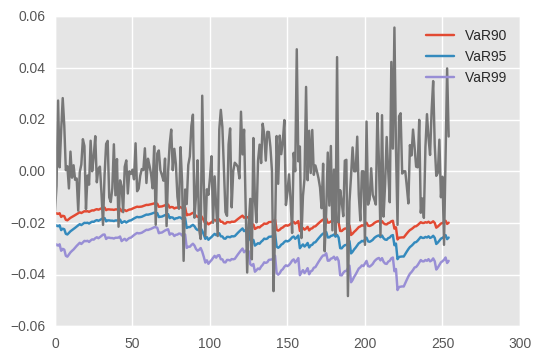

In [502]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_carteira_plot.as_matrix())
plt.legend()

In [503]:
backtesting_parametrico_garch = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 252 dias"])
backtesting_parametrico_garch["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_parametrico_garch

,Excecoes para 252 dias,T = 255 dias
VaR 90,26,16<N<36
VaR 95,15,6<N<21
VaR 99,4,N<7


### 3 - VaR Monte Carlo

In [568]:
def random_walk(mu,sigma,startprice):

    days = 2
    dt = 1/float(days)
    
    price = np.zeros(days)
    shock = np.zeros(days)
    price[0] = startprice
    for i in range(1, days):
        shock[i] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        price[i] = max(0, price[i-1] + shock[i] * price[i-1])
    return (price[-1]/startprice - 1)

#### 3.1 - VaR

In [569]:
def monte_carlo(cotacoes):
    runs = 10000
    
    retornos = cotacoes.pct_change().dropna()
    sigma = retornos.std()
    mu = retornos.mean()
    startprice = cotacoes[-1]
    simulations = []
    for run in range(runs):
        simulations.append(random_walk(mu,sigma,startprice))
    simulations = pd.DataFrame([simulations]).transpose()
    return simulations

simulations = monte_carlo(cotacoes_carteira)

In [570]:
var_99_montecarlo = simulations.quantile(0.01)[0]
var_95_montecarlo = simulations.quantile(0.05)[0]
var_90_montecarlo = simulations.quantile(0.10)[0]

In [571]:
var_montecarlo = pd.DataFrame(index =[0.90,0.95,0.99])
var_montecarlo['VaR(%)'] = [var_90_montecarlo*100,var_95_montecarlo*100,var_99_montecarlo*100]

In [572]:
var_montecarlo

,VaR(%)
0.90,-1.332757
0.95,-1.704842
0.99,-2.418913


### 3.2 - BackTesting

In [573]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
for x in range(inicio,final):
   
    lista_var95.append(monte_carlo(cotacoes_carteira.ix[x-30:x]).quantile(0.05)[0])
    if lista_var95[-1] > retornos_carteira.iloc[x-1]:
        count95 += 1
        
    lista_var90.append(monte_carlo(cotacoes_carteira.ix[x-30:x]).quantile(0.10)[0])
    if lista_var90[-1] > retornos_carteira.iloc[x-1]:
        count90 += 1
        
    lista_var99.append(monte_carlo(cotacoes_carteira.ix[x-30:x]).quantile(0.01)[0])
    if lista_var99[-1] > retornos_carteira.iloc[x-1]:
        count99 += 1

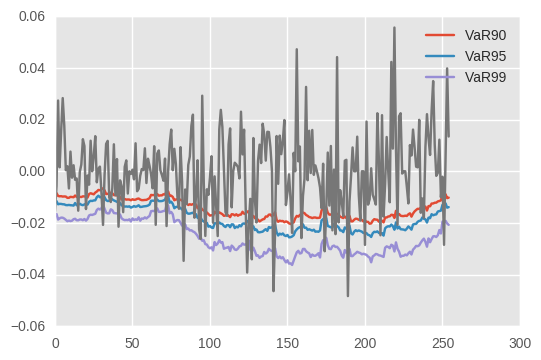

In [574]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_carteira_plot.as_matrix())
plt.legend()

In [575]:
backtesting_montecarlo = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 252 dias"])
backtesting_montecarlo["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_montecarlo

,Excecoes para 252 dias,T = 255 dias
VaR 90,42,16<N<36
VaR 95,27,6<N<21
VaR 99,11,N<7


### 4 - Using Copulas to Evaluate Market Risk

<img src="image.JPG">



This example shows how to model the market risk of a hypothetical global equity index portfolio with a Monte Carlo simulation technique using a Student's t copula and Extreme Value Theory (EVT). The process first extracts the filtered residuals from each return series with an asymmetric GARCH model, then constructs the sample marginal cumulative distribution function (CDF) of each asset using a Gaussian kernel estimate for the interior and a generalized Pareto distribution (GPD) estimate for the upper and lower tails. A Student's t copula is then fit to the data and used to induce correlation between the simulated residuals of each asset. Finally, the simulation assesses the Value-at-Risk (VaR) of the hypothetical global equity portfolio over a one month horizon.

Note that this is a relatively advanced, comprehensive example that assumes some familiarity with EVT and copulas. For details regarding estimation of generalized Pareto distributions and copula simulation, see the Modelling Tail Data with the Generalized Pareto Distribution and Simulating Dependent Random Variables Using Copulas in the Statistics and Machine Learning Toolbox™. For details regarding the approach upon which most of this example is based, see references [5] and [6] by Nystrom and Skoglund in the bibliography.


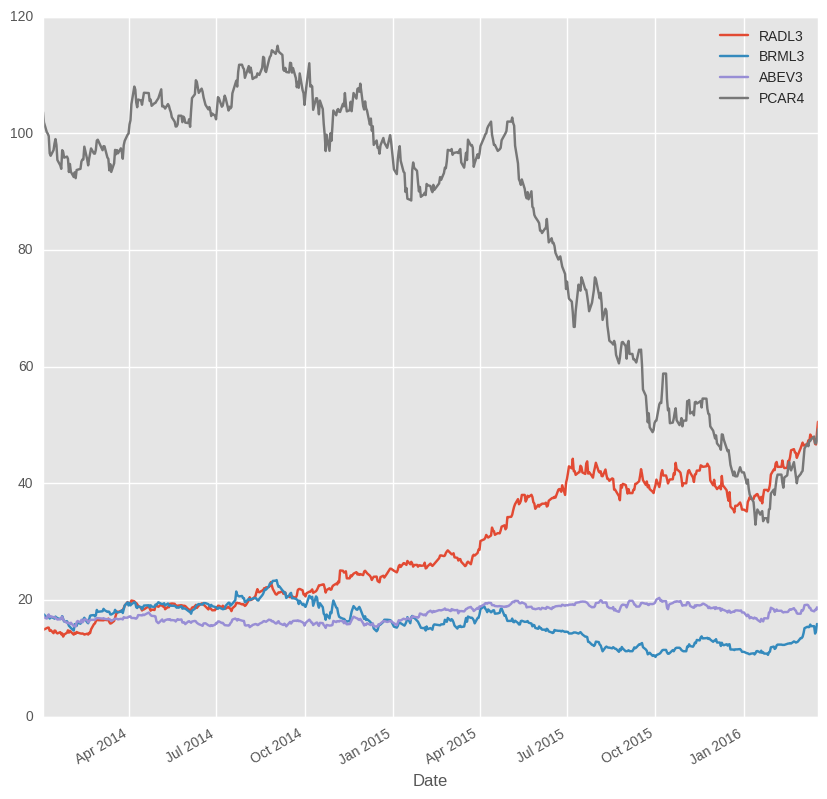

In [512]:
cotacoes.plot(figsize= (10,10))

In preparation for subsequent modeling, convert the closing level of each index to daily logarithmic returns (sometimes called geometric, or continuously compounded, returns).

Since the first step in the overall modeling approach involves a repeated application of GARCH filtration and Extreme Value Theory to characterize the distribution of each individual equity index return series, it is helpful to examine the details for a particular country. You can change the next line of code to any integer in the set {1,2,3,4,5,6} to examine the details for any index.

## Filter the Returns for Each Index

Fonte de estudo para essa parte: https://www.otexts.org/fpp/8/3
https://pypi.python.org/pypi/arch/3.0#bootstrap

Modeling the tails of a distribution with a GPD requires the observations to be approximately independent and identically distributed (i.i.d.). However, most financial return series exhibit some degree of autocorrelation and, more importantly, heteroskedasticity.

For example, the sample autocorrelation function (ACF) of the returns associated with the selected index reveal some mild serial correlation.

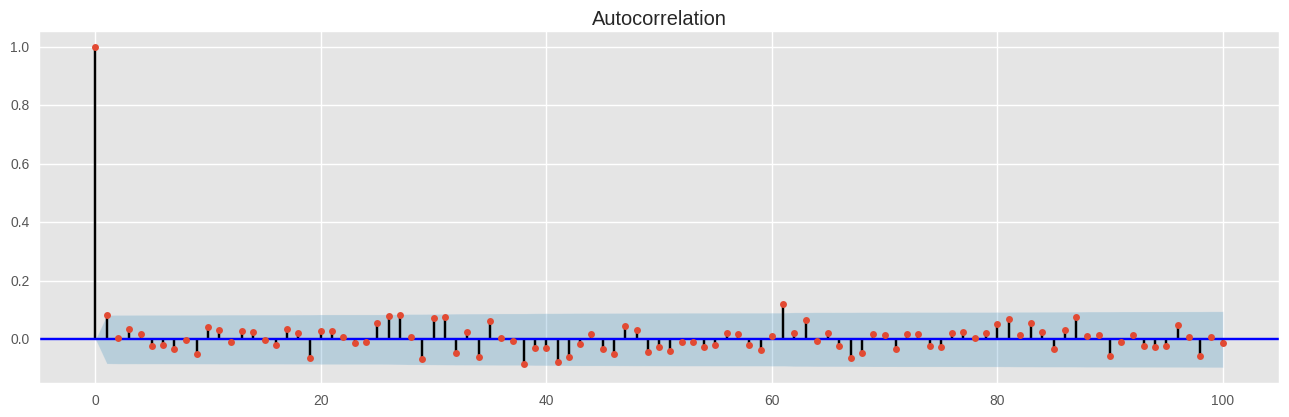

In [587]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(retornos.ix[:,3], lags=100, ax=ax1)

However, the sample ACF of the squared returns illustrates the degree of persistence in variance, and implies that GARCH modeling may significantly condition the data used in the subsequent tail estimation process.

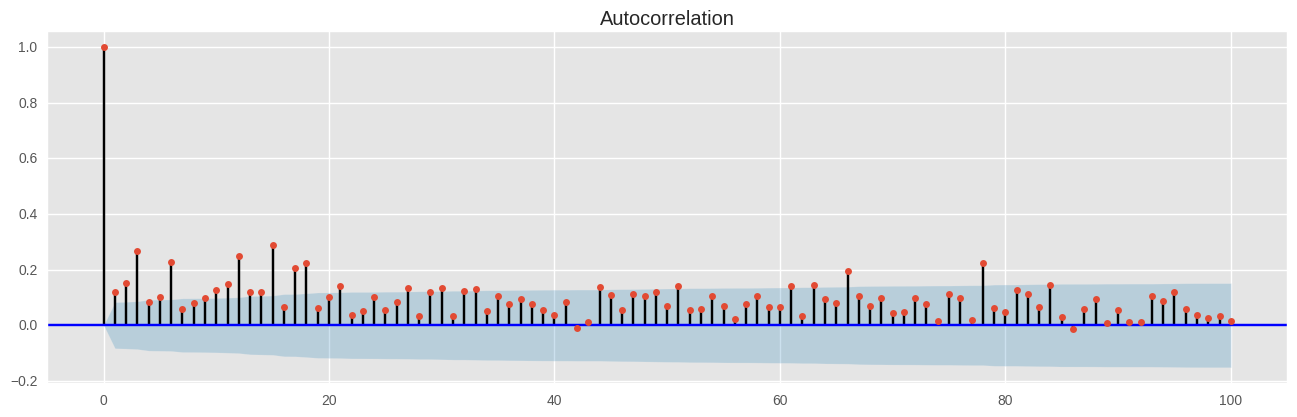

In [600]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(retornos.ix[:,3]**2, lags=100, ax=ax1)

To produce a series of i.i.d. observations, fit a first order autoregressive model to the conditional mean of the returns of each equity index

$$r_t = c + \theta r_{t-1} + \epsilon_t$$

and an asymmetric GARCH model to the conditional variance

$$\sigma^2_t = \kappa + \alpha\sigma^2_{t-1} + \phi\epsilon^2_{t-1} $$

The first order autoregressive model compensates for autocorrelation, while the GARCH model compensates for heteroskedasticity. 

Additionally, the standardized residuals of each index are modeled as a standardized Student's t distribution to compensate for the fat tails often associated with equity returns. That is

$$z_t = \epsilon_t/\sigma_t$$ i.i.d. distributed $$t(\nu)$$

The following code segment extracts the filtered residuals and conditional variances from the returns of each equity index.

In [657]:
retornos.to_csv('retornos.csv')

In [660]:
os.system('R < fitArch.R --no-save')

0

In [711]:
parametros = pd.read_csv('parametros.csv')
parametros = parametros.drop('Unnamed: 0', 1).transpose()
parametros.columns = ativos

In [689]:
residuos = pd.read_csv('residuos.csv')
residuos = residuos.drop('Unnamed: 0', 1).transpose().reset_index(drop=True)
residuos.columns = ativos

In [690]:
volatilidade_condicional = pd.read_csv('volatilidade.csv')
volatilidade_condicional = volatilidade_condicional.drop('Unnamed: 0', 1).transpose().reset_index(drop=True)
volatilidade_condicional.columns = ativos

In [698]:
residuos_normalizados = residuos/volatilidade_condicional

,RADL3,BRML3,ABEV3,PCAR4
V1,1.990020e-03,-0.000414,0.000170,-0.000613
V2,3.722597e-04,0.000015,0.000004,0.000004
V3,2.674501e-02,0.081641,0.043790,0.079958
V4,1.000000e-01,0.100000,0.100000,0.100000
V5,1.000000e-08,0.902107,0.938049,0.914634
V6,2.000000e+00,2.000000,2.000000,2.000000
V7,1.000000e+00,1.000000,1.000000,1.000000
V8,1.000000e+01,6.479571,6.775069,10.000000


For the selected index, compare the model residuals and the corresponding conditional standard deviations filtered from the raw returns. The lower graph clearly illustrates the variation in volatility (heteroskedasticity) present in the filtered residuals.

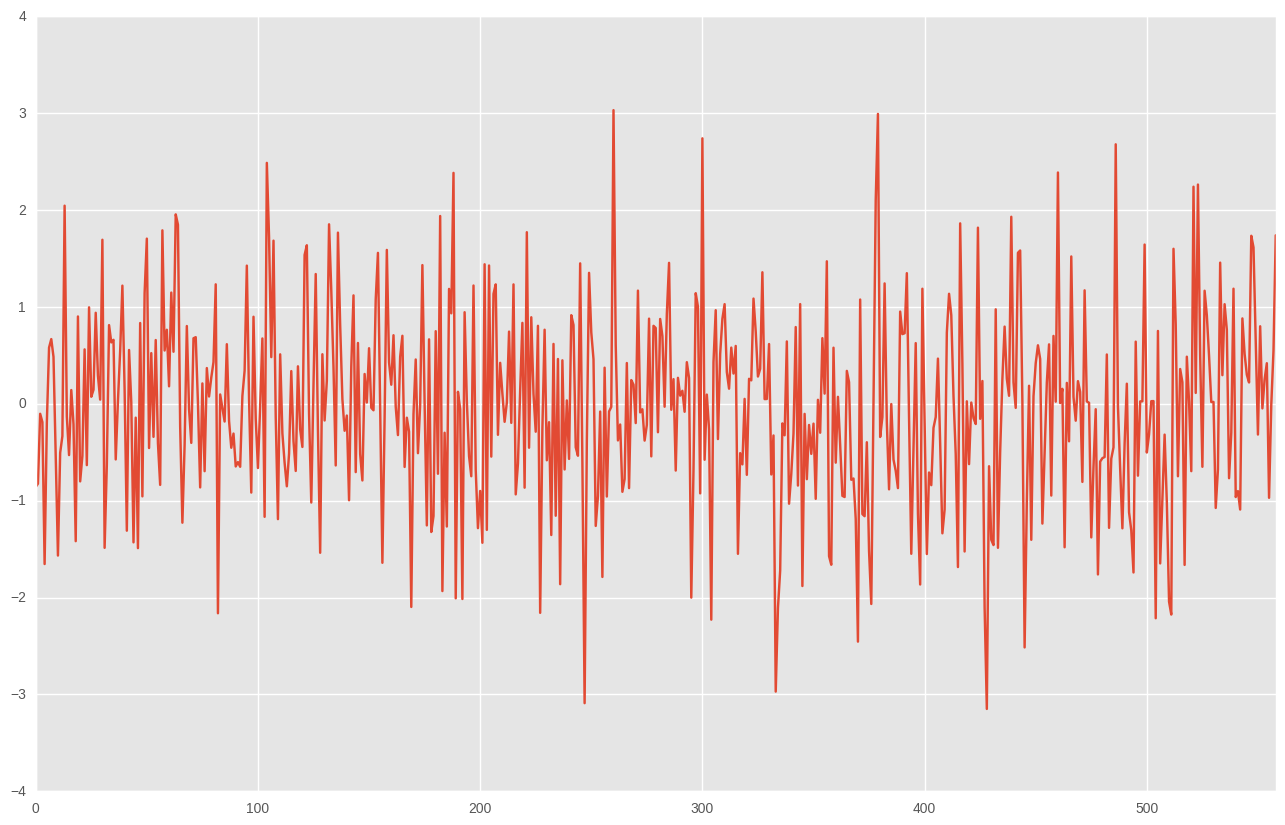

In [754]:
residuos_normalizados.ix[:,3].plot(figsize=(16,10))

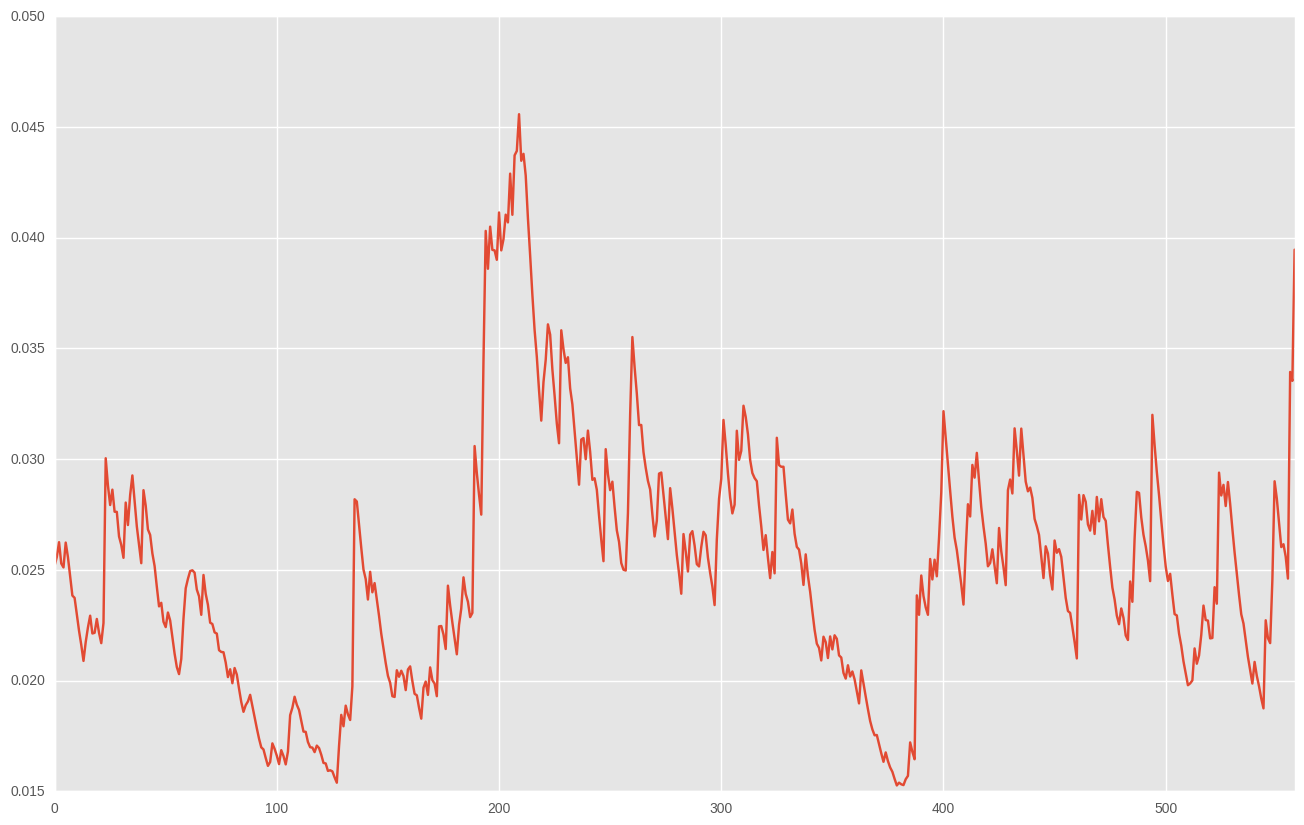

In [695]:
volatilidade_condicional.ix[:,1].plot(figsize=(16,10))

Having filtered the model residuals from each return series, standardize the residuals by the corresponding conditional standard deviation. These standardized residuals represent the underlying zero-mean, unit-variance, i.i.d. series upon which the EVT estimation of the sample CDF tails is based.

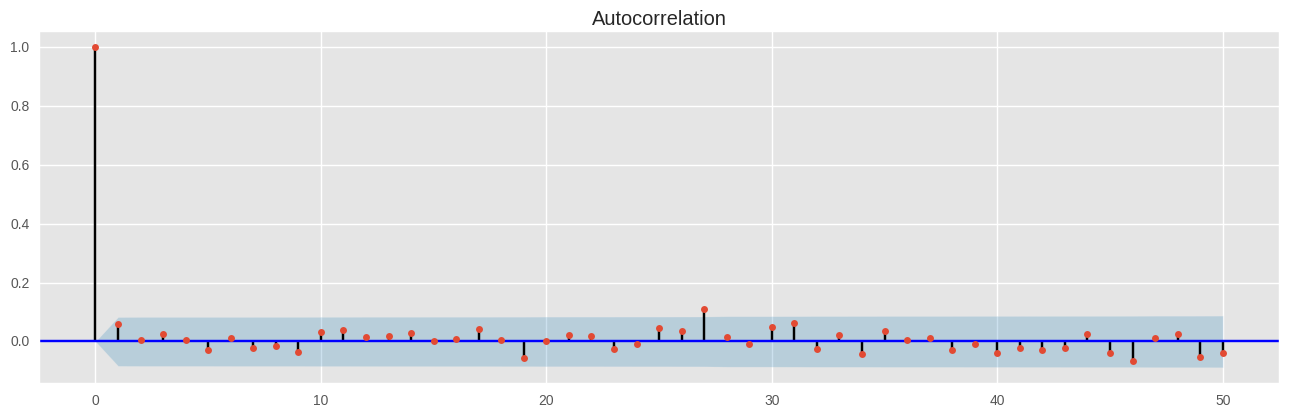

In [704]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuos_normalizados.ix[:,3], lags=50, ax=ax1)

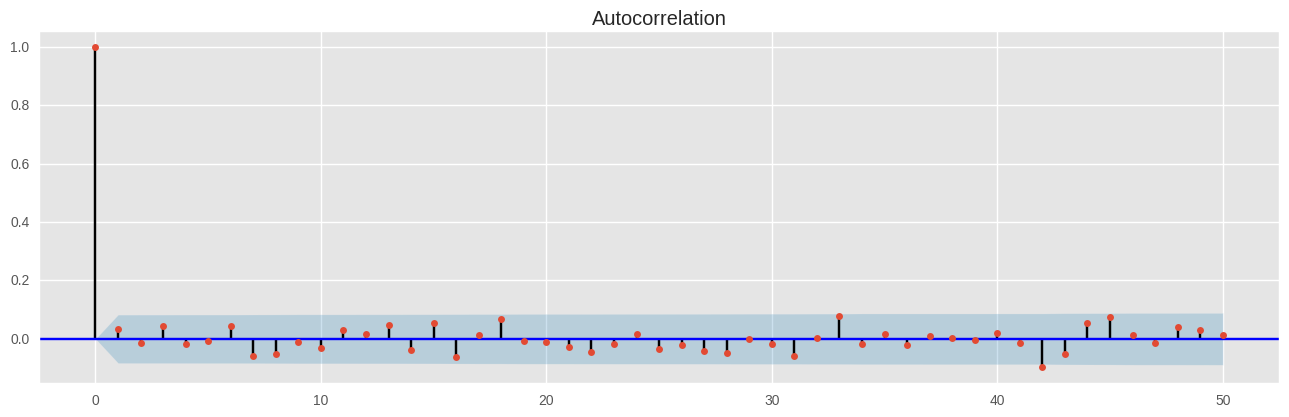

In [705]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residuos_normalizados.ix[:,3]**2, lags=50, ax=ax1)

Estimate the Semi-Parametric CDFs

In [714]:
uniforms = pd.DataFrame()
for x in range(N):
    uniforms[ativos[x]] = t.cdf(residuos_normalizados[ativos[x]],parametros[ativos[x]]['V8'])

In [715]:
uniforms.corr()

,RADL3,BRML3,ABEV3,PCAR4
RADL3,1.000000,0.253627,0.276143,0.272446
BRML3,0.253627,1.000000,0.405995,0.429030
ABEV3,0.276143,0.405995,1.000000,0.423181
PCAR4,0.272446,0.429030,0.423181,1.000000


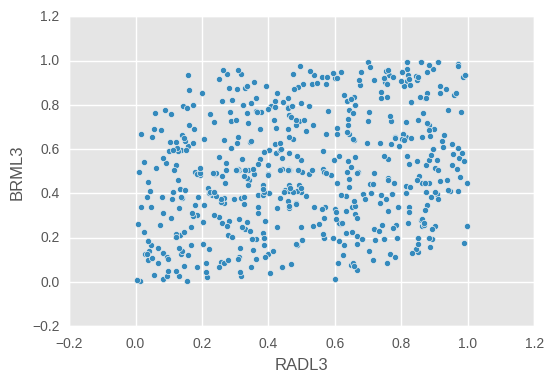

In [716]:
uniforms.ix[:,:2].plot(kind = 'scatter', x= 0, y = 1)

In [717]:
uniforms.to_csv('uniforms.csv')

### Simulandos os valores com a Copula simulada

### Calculando os valores ótimos

Nessa parte foi usado a função fitCopula do R

In [718]:
os.system('R < copulafit.R --no-save')

0

In [719]:
parametros_otimos = pd.read_csv('ParametrosOtimo.csv')
parametros_otimos = parametros_otimos.drop('Unnamed: 0', 1)
parametros_otimos

,x
0,0.354660
1,0.361083
2,0.343108
3,0.514919
4,0.541791
5,0.518011
6,11.182010


In [720]:
simulados = pd.read_csv('CopulaOtimaSimulada.csv')
simulados = simulados.drop('Unnamed: 0', 1)

In [721]:
simulados.corr()

,V1,V2,V3,V4
V1,1.000000,0.256220,0.278704,0.339085
V2,0.256220,1.000000,0.463040,0.482135
V3,0.278704,0.463040,1.000000,0.553050
V4,0.339085,0.482135,0.553050,1.000000


/usr/local/lib/python3.5/dist-packages/seaborn/matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/usr/local/lib/python3.5/dist-packages/seaborn/matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


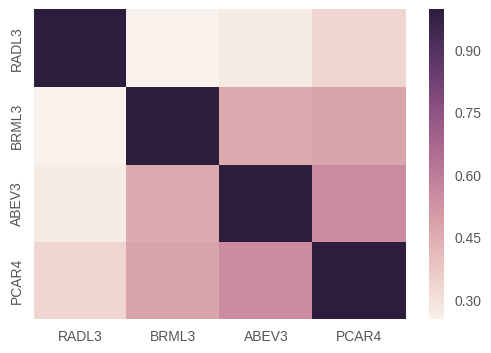

In [722]:
sns.heatmap(simulados.corr(), 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [723]:
simulados.head()

,V1,V2,V3,V4
0,0.979613,0.998238,0.983407,0.914652
1,0.854251,0.470833,0.804197,0.776783
2,0.314607,0.271461,0.033941,0.020287
3,0.215200,0.374188,0.069285,0.089748
4,0.680614,0.606054,0.822387,0.882438


In [724]:
simulado_final = pd.DataFrame()

for x in range(N):
    simulado_final[ativos[x]] = t.ppf(simulados['V'+str(x+1)], parametros[ativos[x]]['V8'],
                                      loc=0, scale=volatilidade_condicional[ativos[x]][-1:])

In [725]:
simulado_final.head()

,RADL3,BRML3,ABEV3,PCAR4
0,0.048016,0.176230,0.043859,0.033197
1,0.022772,-0.003001,0.015054,0.017824
2,-0.010185,-0.025331,-0.035705,-0.052871
3,-0.016803,-0.013209,-0.027616,-0.032461
4,0.009898,0.011065,0.016324,0.028412


In [726]:
simulado_final_carteira = simulado_final.sum(axis=1)/4

In [727]:
simulado_final_carteira.head()

0    0.075325
1    0.013162
2   -0.031023
3   -0.022522
4    0.016425
dtype: float64

In [728]:
simulado_final_carteira.quantile(0.01)*100

-6.226400156066423

### 4.2 - BackTesting

In [742]:
def CopulaTVaR(retornos):
    
    arch_model_fit = []
    N = len(retornos.columns)
    
    retornos.to_csv('retornos.csv')
    os.system('R < fitArch.R --no-save')
    
    parametros = pd.read_csv('parametros.csv')
    parametros = parametros.drop('Unnamed: 0', 1).transpose()
    parametros.columns = ativos
    residuos = pd.read_csv('residuos.csv')
    residuos = residuos.drop('Unnamed: 0', 1).transpose().reset_index(drop=True)
    residuos.columns = ativos
    volatilidade_condicional = pd.read_csv('volatilidade.csv')
    volatilidade_condicional = volatilidade_condicional.drop('Unnamed: 0', 1).transpose().reset_index(drop=True)
    volatilidade_condicional.columns = ativos

    residuos_normalizados = residuos/volatilidade_condicional
    
    uniforms = pd.DataFrame()
    for x in range(N):
        uniforms[ativos[x]] = t.cdf(residuos_normalizados[ativos[x]],parametros[ativos[x]]['V8'])
        
    uniforms.to_csv('uniforms.csv')
    
    # chamando a copulafit do R
    
    os.system('R < copulafit.R --no-save')
    
    simulados = pd.read_csv('CopulaOtimaSimulada.csv')
    simulados = simulados.drop('Unnamed: 0', 1)
    
    simulado_final = pd.DataFrame()

    for x in range(N):
        simulado_final[ativos[x]] = t.ppf(simulados['V'+str(x+1)], parametros[ativos[x]]['V8'], loc=parametros[ativos[x]]['V1'], scale=volatilidade_condicional[ativos[x]].iloc[-1])     

    return simulado_final.sum(axis=1)/4

In [746]:
lista_var95 = []
lista_var99 = []
lista_var90 = []
count95 = 0
count99 = 0
count90 = 0
for x in range(inicio,final):
    var = CopulaTVaR(retornos[x-255:x])
    
    
    lista_var95.append(var.quantile(0.05))
    if lista_var95[-1] > retornos_carteira.iloc[x-1]:
        count95 += 1
        
    lista_var90.append(var.quantile(0.1))
    if lista_var90[-1] > retornos_carteira.iloc[x-1]:
        count90 += 1
        
    lista_var99.append(var.quantile(0.01))
    if lista_var99[-1] > retornos_carteira.iloc[x-1]:
        count99 += 1

In [753]:
var95_copula = lista_var95
var90_copula = lista_var90
var99_copula = lista_var99

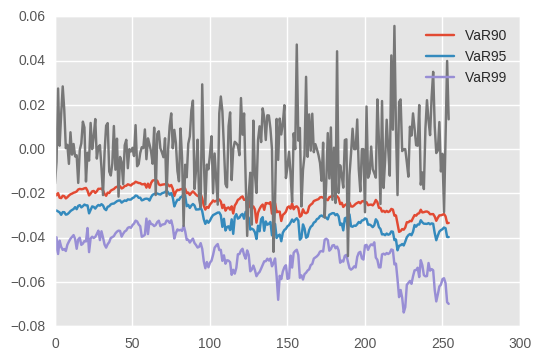

In [747]:
plt.plot(lista_var90, label = 'VaR90')
plt.plot(lista_var95, label = 'VaR95')
plt.plot(lista_var99, label = 'VaR99')
plt.plot(retornos_carteira_plot.as_matrix())
plt.legend()

In [748]:
backtesting_copula = pd.DataFrame([count90,count95,count99] , index = ["VaR 90","VaR 95","VaR 99"], columns =  ["Excecoes para 252 dias"])
backtesting_copula["T = 255 dias"] = ["16<N<36","6<N<21","N<7"]
backtesting_copula

,Excecoes para 252 dias,T = 255 dias
VaR 90,16,16<N<36
VaR 95,6,6<N<21
VaR 99,0,N<7
